<a href="https://colab.research.google.com/github/dekings44/students_companion_bot/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This is the codebase of my masters degree project.**

**Project Title:** *How Effective is AI in Delivering Personalized Learning Paths for Students? A Hands-on Approach with Generative AI.*

**The Problem I am trying to solve:** *This project aims to explore the effectiveness of AI in creating personalized learning paths that caters to individual students’ needs, enhancing learning experience and outcomes.*

**Expected End Product**



> A comprehensive report detailing the AI tutor's effectiveness, measured through metrics like student engagement, understanding, performance, and feedback


> AI Bot Web Embedded Application working prototype capable of delivering personalized learning paths for students based on their individual learning styles, paces, and preferences.


> Working code of the AI Bot


**Name of the AI bot**: **Manda**, *the student companion*


Installation of all the libraries, models and modules that will be needed for this project.

In [1]:
!pip install -U transformers --quiet
!pip install -U accelerate --quiet
!pip install -U bertviz --quiet
!pip install -U umap-learn --quiet
!pip install torch torchvision torchaudio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 114.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.4 MB/s eta 0:00:00


In [2]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


import torch
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification, AdamW
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import AutoTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Masters Project/dataset.csv')

In [4]:
data.head()

Sentence      Type
0  Ali, who was two at the time, loved the story ...  Auditory
1  Look at my dad, spiffed up in jodhpurs, ready ...  Auditory
2  Believe me it's far more difficult to know wha...  Auditory
3  The Surrealists loved bad movies, seeing them ...  Auditory
4  He idolised prize-fighters, regarded racketeer...  Auditory

In [5]:
data['Type'].value_counts()

Visual         5827
Kinesthetic    4819
Auditory       4804
Name: Type, dtype: int64

In [6]:
num_rows, num_columns = data.shape
f'This dataset has {num_rows} rows and {num_columns} columns'

'This dataset has 15450 rows and 2 columns'

In [7]:
classes = data['Type'].unique()
classes

array(['Auditory', 'Visual', 'Kinesthetic'], dtype=object)

In [8]:
# This Function is to clean the dataset and remove the noise
def cleanData(data):
  data = re.sub(r'@[A-Za-z0-9_]+', '', data) # this will remove the @ mentions
  data = re.sub(r'#', '', data) # this will remove the # symbols
  data = re.sub(r'https?:\/\/\s+', '', data) # This will remove the hyperlink
  data = re.sub(r'\n+', '', data) # This will removes all mention of \n
  data = re.sub(r'_', '', data) # This will remove _
  data = re.sub(r'[0-9]', '', data) # This will remove numbers
  return data

In [9]:
data['cleaned_conversation'] = data['Sentence'].apply(cleanData)

**Exploratory Data Analysis**

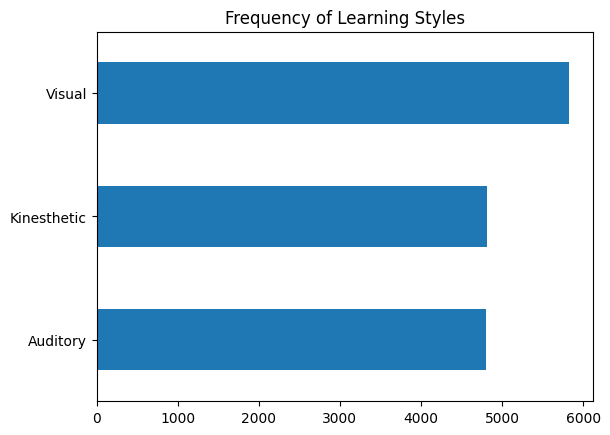

In [10]:
learning_styles = data['Type'].value_counts(ascending=True)
learning_styles.plot.barh()
plt.title('Frequency of Learning Styles')
plt.show()

<Axes: title={'center': 'Words Per Conversation'}, xlabel='Type'>

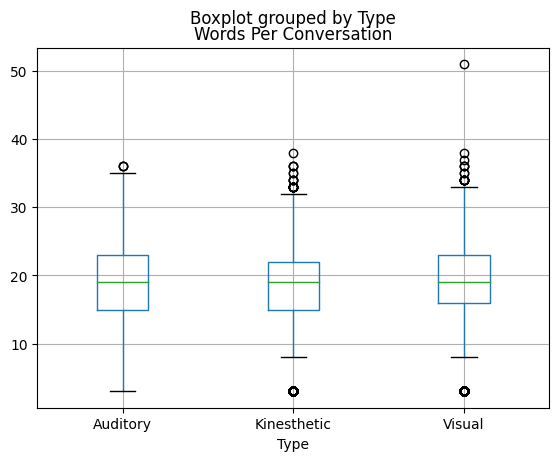

In [11]:
data['Words Per Conversation'] = data['cleaned_conversation'].str.split().apply(len)
data.boxplot("Words Per Conversation", by='Type')

In [12]:
# Assuming df is your DataFrame and 'Type' is the column with labels
labels = data['Type']

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
numerical_labels = label_encoder.fit_transform(labels)

# Add the numerical labels to the DataFrame as a new column, let's call it 'Label'
data['Label'] = numerical_labels

In [13]:
classes = data['Label'].unique()
classes

array([0, 2, 1])

In [14]:
data.head()

Sentence      Type  \
0  Ali, who was two at the time, loved the story ...  Auditory   
1  Look at my dad, spiffed up in jodhpurs, ready ...  Auditory   
2  Believe me it's far more difficult to know wha...  Auditory   
3  The Surrealists loved bad movies, seeing them ...  Auditory   
4  He idolised prize-fighters, regarded racketeer...  Auditory   

                                cleaned_conversation  Words Per Conversation  \
0  Ali, who was two at the time, loved the story ...                      27   
1  Look at my dad, spiffed up in jodhpurs, ready ...                      16   
2  Believe me it's far more difficult to know wha...                      21   
3  The Surrealists loved bad movies, seeing them ...                      16   
4  He idolised prize-fighters, regarded racketeer...                      19   

   Label  
0      0  
1      0  
2      0  
3      0  
4      0

In [15]:
data.shape

(15450, 5)

In [16]:
data.tail()

Sentence         Type  \
15445  Her appearance as the conwoman trying to fleec...  Kinesthetic   
15446  However mostly in these classes I am trying to...  Kinesthetic   
15447  No, I cannot lay down with a hanger hooked on ...  Kinesthetic   
15448  In the meantime, I'm trying to keep the organi...  Kinesthetic   
15449  The deciding run, in the fourth inning, came a...  Kinesthetic   

                                    cleaned_conversation  \
15445  Her appearance as the conwoman trying to fleec...   
15446  However mostly in these classes I am trying to...   
15447  No, I cannot lay down with a hanger hooked on ...   
15448  In the meantime, I'm trying to keep the organi...   
15449  The deciding run, in the fourth inning, came a...   

       Words Per Conversation  Label  
15445                      20      1  
15446                      20      1  
15447                      25      1  
15448                      13      1  
15449                      24      1

In [17]:
sentences = data['cleaned_conversation'].tolist()
learn_style = data['Label'].tolist()

In [18]:
len(sentences)

15450

In [19]:
type(sentences)

list

In [20]:
len(learn_style)

15450

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenized_inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

#tokenized_inputs_array =  np.array(tokenized_inputs) #tokenized_inputs.numpy()

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
print(len(tokenized_inputs), len(learn_style))

3 15450


In [23]:
tokenized_inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [38]:
tokenized_inputs['attention_mask']

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [25]:
print(len(tokenized_inputs['token_type_ids']), len(learn_style))

15450 15450


In [31]:
tokenized_sentences = tokenized_inputs['input_ids']

In [26]:
print(len(tokenized_inputs['input_ids']), len(learn_style))

15450 15450


In [27]:
tokens_first_row = tokenized_inputs['input_ids'][0]

In [28]:
tokens_first_row

tensor([  101,  4862,  1010,  2040,  2001,  2048,  2012,  1996,  2051,  1010,
         3866,  1996,  2466,  2055,  1996,  2210,  2611,  2040,  2973,  1999,
         1037,  9458,  2100,  1010, 16776,  4890,  2160,  1998,  2209,  2007,
         2009,  3723,  1010,  2978,  3723, 10899,  1012,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [29]:
first_row_from_tokens = tokenizer.convert_ids_to_tokens(tokens_first_row)

In [30]:
first_row_from_tokens

['[CLS]',
 'ali',
 ',',
 'who',
 'was',
 'two',
 'at',
 'the',
 'time',
 ',',
 'loved',
 'the',
 'story',
 'about',
 'the',
 'little',
 'girl',
 'who',
 'lived',
 'in',
 'a',
 'teen',
 '##y',
 ',',
 'wee',
 '##ny',
 'house',
 'and',
 'played',
 'with',
 'it',
 '##ty',
 ',',
 'bit',
 '##ty',
 'toys',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
print(tokenized_inputs['token_type_ids'])

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [39]:
input_ids = tokenized_inputs['input_ids']
token_type_ids = tokenized_inputs['token_type_ids']
attention_mask = tokenized_inputs['attention_mask']

**Split Data into Train Validate and Test**

In [40]:
# Splitting the dataset
train_input_ids, test_input_ids, train_token_type_ids, test_token_type_ids, train_attention_mask, test_attention_mask, train_labels, test_labels = train_test_split(
    input_ids, token_type_ids, attention_mask, learn_style, test_size=0.2, random_state=42
)

train_input_ids, val_input_ids, train_token_type_ids, val_token_type_ids, train_attention_mask, val_attention_mask, train_labels, val_labels = train_test_split(
    train_input_ids, train_token_type_ids, train_attention_mask, train_labels, test_size=0.1, random_state=42
)

In [32]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    tokenized_sentences, learn_style, test_size=0.2, random_state=42
)

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    train_inputs, train_labels, test_size=0.1, random_state=42
)


In [37]:
train_inputs

tensor([[ 101, 2265, 2062,  ...,    0,    0,    0],
        [ 101, 2265, 2062,  ...,    0,    0,    0],
        [ 101, 2006, 2089,  ...,    0,    0,    0],
        ...,
        [ 101, 2034, 1010,  ...,    0,    0,    0],
        [ 101, 2002, 3030,  ...,    0,    0,    0],
        [ 101, 2138, 2027,  ...,    0,    0,    0]])

We convert the input data into PyTorch datasets (TensorDataset) and create data loaders to iterate over batches during training, validation, and testing.

In [41]:
train_dataset = torch.utils.data.TensorDataset(train_input_ids, train_attention_mask, torch.tensor(train_labels))
val_dataset = torch.utils.data.TensorDataset(val_input_ids, val_attention_mask, torch.tensor(val_labels))
test_dataset = torch.utils.data.TensorDataset(test_input_ids, test_attention_mask, torch.tensor(test_labels))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)
